# Big Data in Geographic Information Systems - Project 

#  Part 2 - Temperature Trends - Model Data

In this notebook the False Discovery Rate (FDR) approach (Wilks, 2016) described in the first part of the project is applied to temperature data coming from CMIP6 climate models.

After choosing a model, two 5x5 grids are created containing monthly and annual temperature anomalies time series for each cell.

A linear trend is then computed for each cell of the annual grid and its significance tested at the 0.01 level. Tests that do not satisfy the FDR criterion are then discarded.

An interactive plot at the end of the notebook allows to visualize the map of trends and the time series of a selected grid cell.

### Import libraries

In [1]:
import os

import numpy as np
import xarray as xr

import pandas as pd

import datetime as dtm
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs

from tqdm.notebook import tqdm

In [2]:
from matplotlib import cm, colors
from matplotlib.lines import Line2D
from utils import make_colormap
to_rgb = colors.ColorConverter().to_rgb

In [3]:
from tqdm.notebook import tqdm

### Load model data

A few NetCDF files containing historical simulations of surface temperatures from CMIP6 climate models were downloaded from https://esgf-node.llnl.gov/search/cmip6/ with the following settings:

- Experiment ID: historical
- Variant label: r1i1p1f1
- Table ID: Amon
- Frequency: mon
- Variable: ts

Please use a model of your choice (for instance, the model used in the rest of the notebook can be downloaded [here](http://cmip.bcc.cma.cn/thredds/fileServer/cmip6_data/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/Amon/ts/gn/v20181126/ts_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc)).

In [4]:
model_folder = "./data/ts_model_data/" # change as needed
m_variable = model_folder+'ts_Amon_'
m_case = '_historical_r1i1p1f1_gr_185001-201412.nc'

In [5]:
model_files = [file for file in os.listdir(model_folder) if file.endswith("nc")]
for i, f in enumerate(model_files):
    print(f"Model {i}: {f}")

Model 0: ts_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412.nc
Model 1: ts_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc
Model 2: ts_Amon_GISS-E2-1-H_historical_r1i1p1f1_gn_185001-201412.nc
Model 3: ts_Amon_MRI-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc
Model 4: ts_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc
Model 5: ts_Amon_TaiESM1_historical_r1i1p1f1_gn_185001-201412.nc
Model 6: ts_Amon_MIROC6_historical_r1i1p1f1_gn_185001-201412.nc
Model 7: ts_Amon_FGOALS-f3-L_historical_r1i1p1f1_gr_185001-201412.nc
Model 8: ts_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc


In [6]:
modfile = model_folder+"ts_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc"

# Alternatively:
# model_index = 8
# modfile = model_folder + model_files[model_index]

Load model data using `xarray`, converting the temperature to degrees Celsius:

In [7]:
%%time
m1 = xr.open_dataset(modfile)
mod_ts = m1.ts - 273.5 # convert to Celsius

model_name = modfile[len(m_variable):-len(m_case)]
print(f"Loaded temperature data from {model_name}\n")

Loaded temperature data from BCC-CSM2-MR

CPU times: user 395 ms, sys: 127 ms, total: 522 ms
Wall time: 522 ms


Coordinates:

In [8]:
mod_ts.coords

Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat      (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon      (lon) float64 0.0 1.125 2.25 3.375 4.5 ... 355.5 356.6 357.8 358.9

The longitudes range between 0 (Prime meridian) and 360:

In order to more easily reuse some functions from the previos notebook the longitudes will be converted so that they range between -180 and 180:

In [9]:
mod_ts = mod_ts.assign_coords(lon=(((mod_ts.lon + 180) % 360) - 180)).sortby("lon")

In [10]:
mod_ts.coords

Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat      (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon      (lon) float64 -180.0 -178.9 -177.8 -176.6 ... 176.6 177.8 178.9

(Please note: the coordinates of some models are named "latitude" and "longitude" instead of "lat" and "lon". This notebook relises on the latter names, so please uncomment the following cell if necessary)

In [11]:
# mod_ts = mod_ts.rename(latitude = "lat")
# mod_ts = mod_ts.rename(longitude = "lon")

Plot of the average temperatures between 1850 and 2014:

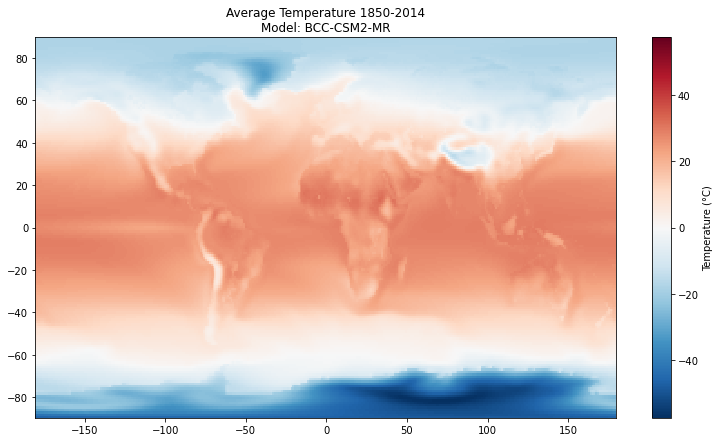

In [12]:
plt.figure(figsize=(13, 7))
mod_ts.mean(axis=0).plot(cbar_kwargs=dict(label="Temperature (°C)"))
plt.xlabel("")
plt.ylabel("")
plt.title(f"Average Temperature 1850-2014\nModel: {model_name}")
plt.show()

Compute anomalies:

In [13]:
%%time
mod_ref = mod_ts.loc['1961':'1990']
mod_normals = mod_ref.groupby("time.month").mean("time")
mod_anomalies = mod_ts.groupby("time.month") - mod_normals

CPU times: user 380 ms, sys: 195 ms, total: 576 ms
Wall time: 574 ms


Set up the variables regarding grid resolution, number of months/years and latitude/longitudes

In [14]:
resol = 5
mod_nmonths = mod_ts.shape[0]
mod_nyears = mod_nmonths/12
mod_grlons = np.arange(-180., 181., resol)
mod_grlats = np.arange(-90., 91., resol)

In [15]:
nlon = len(mod_grlons) - 1
nlat = len(mod_grlats) -1
nlon, nlat

(72, 36)

The following function takes care of creating two 5x5 grids of monthly and annual anomalies:

Monthly and annual datetime ranges:

In [16]:
timeslice_m = pd.date_range(start = "1850", end = "2015", freq = "M")
timeslice_y = pd.date_range(start = "1850", end = "2015", freq = "Y")

In [17]:
def create_grids(anomalies):
    
    # Usa le variabili resol, nmonths, grlons, grlats, nlon, nlat
    
    data_mo = np.empty([mod_nmonths,nlat,nlon],dtype=float)
    data_mo[:,:,:] = np.nan
    
    data_yr = np.empty([int(mod_nyears),nlat,nlon],dtype=float)
    data_yr[:,:,:] = np.nan
    
    for j in tqdm(range(0,nlat)):
        for i in range(0,nlon):
            temp = anomalies.\
                sel(lat=slice(mod_grlats[j], mod_grlats[j+1]), lon=slice(mod_grlons[i],mod_grlons[i+1])).\
                stack(coords=["lat", "lon"]).\
                mean(axis = 1)
                
            data_mo[:,j,i] = np.array(temp)
            data_yr[:,j,i] = pd.Series(data_mo[:,j,i], index = timeslice_m).resample("Y").mean()
            
    return data_mo, data_yr

In [18]:
%%time
mod_data_mo_anom, mod_data_yr_anom = create_grids(mod_anomalies)


CPU times: user 22 s, sys: 81 ms, total: 22 s
Wall time: 22.1 s


It is useful to store this data as xarrays, so that they can be indexed by time, latitude an longitude. For latitudes and longitudes we use the center of each $5\times 5$ cell.

Coordinates for the center of each cell:

In [19]:
xlats = mod_grlats[:-1] + 2.5
xlons = mod_grlons[:-1] + 2.5

Create the two xarrays:

In [20]:
xts_m = xr.DataArray(mod_data_mo_anom, coords=[timeslice_m, xlats, xlons], dims=["time", "lat", "lon"])
xts_y = xr.DataArray(mod_data_yr_anom, coords=[timeslice_y, xlats, xlons], dims=["time", "lat", "lon"])

A few examples of time series relative to a specific cell:

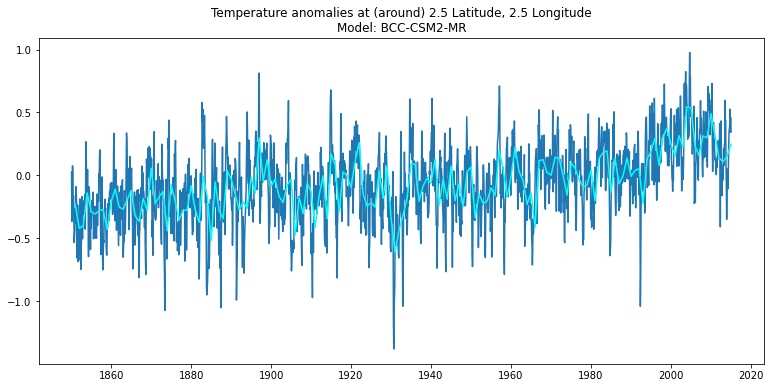

In [21]:
plt.figure(figsize=(13, 6))
lat = 2.5
lon = 2.5
plt.plot(xts_m.time, xts_m.sel(lat = lat, lon = lon, method = "nearest"))
plt.plot(xts_y.time, xts_y.sel(lat = lat, lon = lon, method = "nearest"), color="aqua")
plt.title(f"Temperature anomalies at (around) {lat} Latitude, {lon} Longitude\nModel: {model_name}")
plt.show()

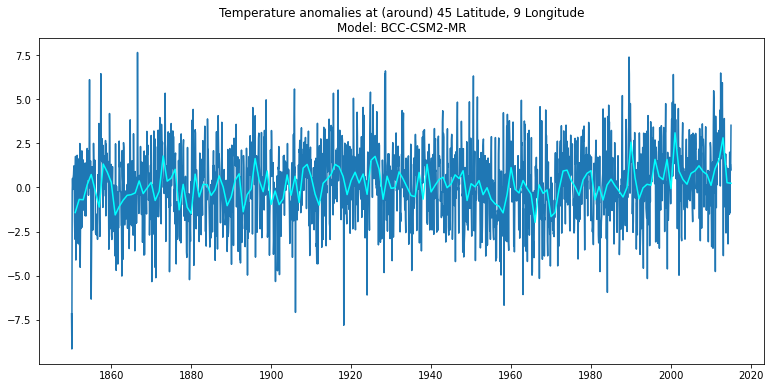

In [22]:
plt.figure(figsize=(13, 6))
lat = 45
lon = 9
plt.plot(xts_m.time, xts_m.sel(lat = lat, lon = lon, method = "nearest"))
plt.plot(xts_y.time, xts_y.sel(lat = lat, lon = lon, method = "nearest"), color="aqua")
plt.title(f"Temperature anomalies at (around) {lat} Latitude, {lon} Longitude\nModel: {model_name}")
plt.show()

### Linear Trend Estimation and Significance with FDR Approach

`fdr.py` contains most of the functions used in the notebook for part 1 to compute the trends, p values and $p^*_{\mathrm{FDR}}$. We start by performing the t tests.

In [23]:
import fdr

In [24]:
mod_pvs, mod_ints, mod_trends = fdr.t_tests(mod_data_yr_anom)

We also transform the arrays containing the p values, intercepts and trends into xarrays, which will be useful later.

In [25]:
xtrends = xr.DataArray(mod_trends, coords=[xlats, xlons], dims=["lat", "lon"])
xints = xr.DataArray(mod_ints, coords=[xlats, xlons], dims=["lat", "lon"])
xpvs = xr.DataArray(mod_pvs, coords=[xlats, xlons], dims=["lat", "lon"])

We use 0.01 as the significance level for local tests and as the value of $\alpha_{\mathrm{FDR}}$.

In [26]:
alpha_local = 0.01
alpha_FDR = alpha_local

We now compute the value of $p^*_{\mathrm{FDR}}$:

In [27]:
p_FDR = fdr.find_p_FDR(mod_pvs, alpha_FDR)
p_FDR

0.007977067430628263

A local null hypothesis in a cell is rejected if the corresponding $p$ values is no larger than $p^*_{\text{FDR}}$ (FDR criterion).

How many tests do not safisfy the FDR criterion?

In [28]:
a = np.sum(mod_pvs <= alpha_local) - np.sum(mod_pvs <= p_FDR)
b = np.sum(mod_pvs <= alpha_local)
print(f"{a}/{b} locally rejected tests do not satisfy the FDR criterion")

31/2102 locally rejected tests do not satisfy the FDR criterion


Latitudes and longitudes of locally rejected tests:

In [29]:
rej_pvs_x, rej_pvs_y = np.where(mod_pvs <= alpha_local)
rej_pvs_lats = [xlats[i] for i in rej_pvs_x]
rej_pvs_lons = [xlons[i] for i in rej_pvs_y]

Latitudes and longitudes of tests that satisfy the FDR approach:

In [30]:
fdr_pvs_x, fdr_pvs_y = np.where(mod_pvs <= p_FDR)
fdr_pvs_lats = [xlats[i] for i in fdr_pvs_x]
fdr_pvs_lons = [xlons[i] for i in fdr_pvs_y]

Plot:

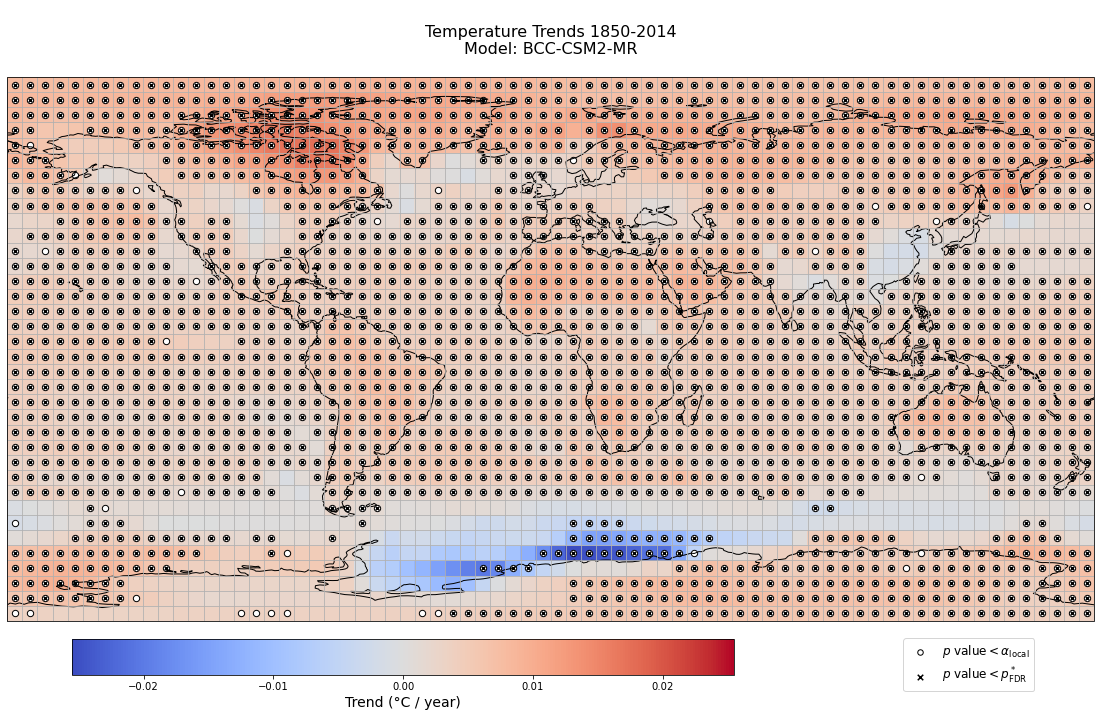

In [31]:
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines() 
ax.gridlines(xlocs=range(-180,181,resol), ylocs=range(-90,91,resol))
# ax.stock_img()

# Title
ax.set_title(f'\nTemperature Trends 1850-2014\nModel: {model_name}\n', size=16)

# Colormap

mx = np.nanmax(np.abs(xtrends))
norm = mpl.colors.Normalize(vmin=-mx,vmax=mx)
cmap = cm.coolwarm

## Pcolormesh
plt.pcolormesh(mod_grlons, mod_grlats, xtrends, cmap=cmap, norm=norm)

# Scatter
ax.scatter(rej_pvs_lons, rej_pvs_lats, edgecolor='black', facecolor='white', label=r"$p$ value$< \alpha_{\mathrm{local}}$", s = 40)
ax.scatter(np.array(fdr_pvs_lons), fdr_pvs_lats, marker="x",  edgecolor="black", facecolor='black',
           s=12, label= r"$p$ value$< p^*_{\mathrm{FDR}}$")

lgnd = plt.legend(loc='lower right', bbox_to_anchor=(0.95,-0.14), prop={"size":12})
#change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]

# Colorbar
cbar_ax = fig.add_axes([0.18, 0.05, 0.46, 0.05])
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cbar_ax, orientation='horizontal')
cbar.set_label('Trend (°C / year)', size=14)
cbar.ax.tick_params(labelsize=10)

plt.show()

We can observe that most of the "locally" significant trends also satisfy the FDR criterion.

### Interactive plot with map and timeseries (requires ipywidgets)

Let us now create an interactive plot which includes both a map with trends (the same as before) and the temperature anomalies time series for each cell, including the estimated linear trends and $p$ values. One can choose the latitude and longitude of the cell, whether to display the markers regarding the rejection of the test on the significance of the related trend, and whether to fix the $y$ axis in order to more easily compare the data from different cells.

In [32]:
import ipywidgets as widgets
import datetime
from matplotlib.offsetbox import AnchoredText

In [33]:
y_min = np.nanmin(xts_m)
y_max = np.nanmax(xts_m)

def interactive_plot(lat, lon, fixed_yaxis, show_tests):
    
    a = xints.sel(lat=lat, lon=lon, method="nearest").values
    b = xtrends.sel(lat=lat, lon=lon, method="nearest").values
    reg_line = a + b * np.arange(timeslice_y.shape[0])
    
    fig = plt.figure(figsize=(25,8))
    a1 = plt.subplot(121, projection=ccrs.PlateCarree())
    a2 = plt.subplot(122)
    
    ##########
    # Plot 1 #
    ##########
    
    a1.set_global()
    a1.coastlines() 
    a1.gridlines(xlocs=range(-180,181,resol), ylocs=range(-90,91,resol))
    
    # Pcolormash
    a1.pcolormesh(mod_grlons, mod_grlats, xtrends, cmap=cmap, norm=norm)
    a1.set_title(f'\nTemperature Trends 1850-2014\nModel: {model_name}\n', size=16)
    
    # Scatter
    if show_tests:
        # a1.scatter(rej_pvs_lons, rej_pvs_lats, edgecolor='black', facecolor='white', label=r"$p$ value$< \alpha_{\mathrm{local}}$", s = 40,
                  # alpha = 0.5)
        a1.scatter(np.array(fdr_pvs_lons), fdr_pvs_lats, marker="o",  edgecolor="black", facecolor='white', alpha = 0.5,
                   s=20, label= r"$p$ value$< p^*_{\mathrm{FDR}}$")

    
    ##########
    # Plot 2 #
    ##########
    
    Y = xts_y.sel(lat=lat, lon=lon, method="nearest")
    Ym = xts_m.sel(lat=lat, lon=lon, method="nearest")
    a2.plot(timeslice_m, Ym)
    a2.plot(timeslice_y, Y, color="aqua", label = "Annual average")
    a2.plot(timeslice_y, reg_line, color='r', label="Trend")
    a2.legend(loc = "lower right")
    
    # xlim/ylim
    if fixed_yaxis:
        a2.set_ylim(y_min, y_max)
    
    # Convert, e.g., "-10, 10" to "10 S, 10 E"
    lat_str = f"{np.abs(lat)}"
    lat_str = lat_str+" N" if lat > 0 else lat_str+" S"
    lon_str = f"{np.abs(lon)}"
    lon_str = lon_str+" E" if lat > 0 else lon_str+" W"
    
    # Time series
    a2.set_title(f"Monthly Temperature Anomalies at {lat_str}, {lon_str}", size=14)
    p = xpvs.sel(lat=lat, lon=lon).values
    t = xtrends.sel(lat=lat, lon=lon).values
    if p < 1e-3:
        p_str = f"$p$ value: {p:4.3e}\n"
    else:
        p_str = f"$p$ value: {p:4.4f}\n"
    anchored_text = AnchoredText(p_str + f"Trend: {t:4.5f} °C / year", loc=2, borderpad=0.0, frameon=False, prop=dict(size=12))
    a2.add_artist(anchored_text)
    
    
    a2.yaxis.set_label_position("right")
    a2.yaxis.tick_right()
    
    # Moving Marker
    a1.plot(lon, lat, marker = "s", color="magenta", markersize=8, fillstyle="full", label="Current position", lw=0)
    if show_tests:
        lgnd = a1.legend(loc='lower right', bbox_to_anchor=(0.95,-0.19), prop={"size":11})
    else:
        lgnd = a1.legend(loc='lower right', bbox_to_anchor=(0.95,-0.125), prop={"size":11})
    # a1.plot(lon, lat, marker = "x", color="", markersize=7, fillstyle="full")
    lgnd.legendHandles[0]._sizes = [30]
    lgnd.legendHandles[1]._sizes = [30]
    
    fig.tight_layout()
    
    ############
    # Colorbar #
    ############
    
    cbar_ax = fig.add_axes([0.235, 0.25, 0.25, 0.05]) #[left, bottom, width, height]
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                 cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Trend (°C / year)', size=14)
    cbar.ax.tick_params(labelsize=10)

    plt.show()
    

In [34]:
lat_slider = widgets.FloatSlider(min=-87.5, max=87.5, value=42.5, step = 5,
                                description="Latitude")
lon_slider = widgets.FloatSlider(min=-177.5, max=177.5, value=12.5, step = 5,
                                description="Longitude")
fix_y_checkbox =   widgets.Checkbox(value=False, description='Fix y axis')
tests_checkbox =   widgets.Checkbox(value=True, description='Show tests')

out = widgets.interactive_output(interactive_plot, {"lat" : lat_slider, "lon" : lon_slider,
                                              "fixed_yaxis":fix_y_checkbox,
                                              "show_tests":tests_checkbox})
out.layout.height = '500px'
ui = widgets.HBox([lat_slider, lon_slider, tests_checkbox, fix_y_checkbox])

display(ui, out)


Output(layout=Layout(height='500px'))